# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import dense_rank
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, desc
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import col, expr, when
from statsmodels.stats.proportion import proportions_ztest
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import pandas as pd
import re
import copy
import time
import datetime
import seaborn as sbrn
import matplotlib.pyplot as plt
%matplotlib inline

#set seaborn style
sbrn.set(style="whitegrid")

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
print(df.head())
df.printSchema()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullab

In [5]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [6]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [7]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [8]:
# get the count of the dataset before we do any cleaning - this is 286500
df.count()

286500

## Clean Data

##### Delete rows with missing values

In [9]:
# Check and delete rows with na values in userid and sessions id
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])
print(df.count())

286500


In [10]:
# Check for empty strings
print(df.filter(df['userId']=='').count())
print(df.filter(df['sessionId']=='').count())

8346
0


In [11]:
# remove those with an empty string userId
df = df.filter(df["userId"] != "")
print('Record count after removing rows with empty userIds:', df.count())

Record count after removing rows with empty userIds: 278154


In [12]:
# drop userid duplicates
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [13]:
# drop sessionid duplicates
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [14]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [15]:
# View the dataframe
df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
# Cancellation confirmed page selection
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [17]:
# Count of churned users who went through confirmed cancellation page
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

Now we can create a churn column based on above logic in function which flags 1 for user cancellations and 0 otherwise.

In [18]:
# flags 1 for Cancellation Confirmation page is reached and 0 otherwise
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [19]:
#  churn column in the dataframe
df = df.withColumn("churn", churn_event("page"))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [20]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [21]:
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  225|
+-----+-----+



### Exploratory Data Analysis for users:  Current vs Churned

In [22]:
# Convert dataframe to pandas for visualisation
df_churn = df_churn.toPandas()

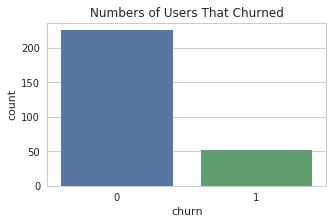

In [23]:
# plot the number of users that churned
plt.figure(figsize = [5,3])
ax = sbrn.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Numbers of Users That Churned");

#### Length of time spent by users

In [24]:
# Select length of time spent and remove null values 
p_df = df.select("length").toPandas().dropna()

In [25]:
p_df.head()

,length
0,277.89016
1,236.09424
2,282.82730
3,262.71302
4,223.60771


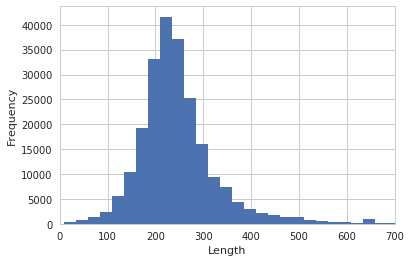

In [26]:
# plot the distribution
bin_edges = np.arange (10, p_df['length'].max()+25, 25)
plt.hist(data = p_df, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

#### Compare Churn vs Stayed users with respect to their gender

In [27]:
# create gender df grouped by gender and their churn results
gender_df = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [28]:
gender_df = gender_df.toPandas().sort_values('count', ascending = False)

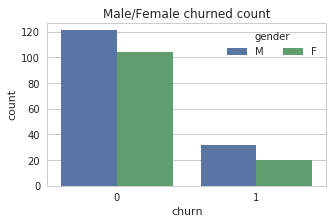

In [29]:
# seaborn barplot
plt.figure(figsize = [5,3])
ax = sbrn.barplot(data = gender_df, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Male/Female churned count");

#### Compare Churn vs Stayed users in their subscription terms - Paid / Free

In [30]:
# Create dataframe for Subscription level type for churned and stayed users
df_SubscriptionType = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [31]:
df_SubscriptionType.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|    0|  165|
| free|    0|  195|
| paid|    1|   31|
| free|    1|   21|
+-----+-----+-----+



In [32]:
# convert spark dataframe to pandas dataframe for plotting
df_SubscriptionType = df_SubscriptionType.toPandas() 

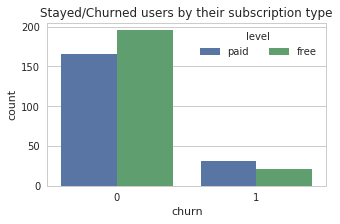

In [33]:
# Visualize the trend via barplot using seaborn
plt.figure(figsize = [5,3])
ax = sbrn.barplot(data = df_SubscriptionType, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Stayed/Churned users by their subscription type");

Noticeably in above pattern, free users had most likely churned than their regular counterparts.

In [34]:
# Also evident by their respective churn rate

In [35]:
# | paid|    0|  165|
# | free|    0|  195|
# | paid|    1|   31|
# | free|    1|   21|

print("Free churn rate " , (21/(21+195)))
print("Paid churn rate " , (31/(31+165)))

Free churn rate  0.09722222222222222
Paid churn rate  0.15816326530612246


#### Compare Churn vs Stayed users with respect to visited pages

We can analyse pages visited by churned users when compared to stayed users

In [36]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [37]:
df_page.show(20)

+--------------------+-----+------+
|                page|churn| count|
+--------------------+-----+------+
|           Thumbs Up|    0| 12551|
|             Upgrade|    0|   499|
|              Cancel|    0|    52|
|              Logout|    0|  3226|
|            NextSong|    0|228108|
|      Submit Upgrade|    0|   159|
|                Help|    0|  1454|
|       Save Settings|    0|   310|
|                Home|    0| 10082|
|     Add to Playlist|    0|  6526|
|            Settings|    0|  1514|
|         Thumbs Down|    0|  2546|
|         Roll Advert|    0|  3933|
|          Add Friend|    0|  4277|
|Cancellation Conf...|    1|    52|
|               Error|    0|   252|
|           Downgrade|    0|  2055|
|               About|    0|   495|
|    Submit Downgrade|    0|    63|
+--------------------+-----+------+



In [38]:
# Convert spark to pandas dataframe
df_page = df_page.toPandas()

In [39]:
# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [40]:
# calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count']))

In [41]:
df_page.head(20)

,page,churn,count,rate
0,Thumbs Up,0,12551,0.045131
1,Upgrade,0,499,0.001794
2,Cancel,0,52,0.000187
3,Logout,0,3226,0.011600
4,NextSong,0,228108,0.820231
5,Submit Upgrade,0,159,0.000572
6,Help,0,1454,0.005228
7,Save Settings,0,310,0.001115
8,Home,0,10082,0.036253
9,Add to Playlist,0,6526,0.023466


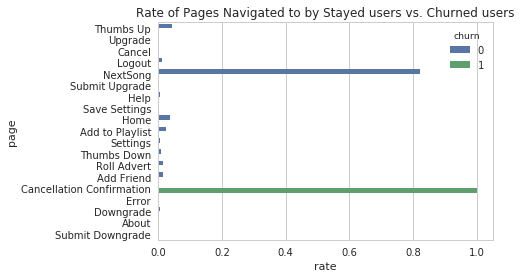

In [42]:
#plot by pages visited by churn users
plt.figure(figsize=[6,4])
sbrn.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Stayed users vs. Churned users');

Form the graph we notice that the churn user visited cancel confirmation page directly without going to any other pages. Also a fact apparently is that the loyal users had often clicked Thumbs up and Next Song page button.

#### Churned time lapsed since registration in Sparkify 

Here we can see the user churned since they registered on Sparkify.

In [43]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [44]:
# order by latest timestamp first
w = Window.partitionBy('userId').orderBy(col('ts').desc())

In [45]:
# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [46]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [47]:
# just get those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [48]:
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

Removing the number of days in timestamp since registration

In [49]:
# Timestamp minus registration date 
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [50]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [51]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [52]:
# to Pandas for the plot
df_days_pd = df_days.toPandas()

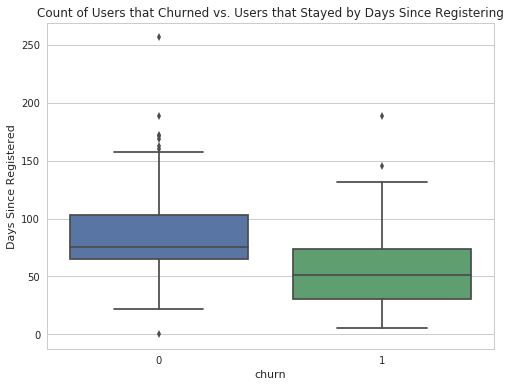

In [53]:
# plot boxplot
plt.figure(figsize=[8,6])
sbrn.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered");

#### Location of the churn / stay users

In [54]:
# View churn data by location
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



In [55]:
# Store location wise (city name) users along with churn flag
location_count = df.select("location", "userId", "churn").groupby("location").count()

In [56]:
# Create a function for getting state being last two characters from city name
get_state = udf(lambda x: x[-2:])

In [57]:
# create state column
df_state = df.withColumn("state", get_state(df.location))

In [58]:
# check that create state column worked
df_state_pd = df_state.toPandas()
df_state_pd.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,state
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,CA
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,NH


In [59]:
# Create statewise pandas dataframe using state, churn column while remove duplicates
df_state_pd = (df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()).toPandas()

In [60]:
df_state_pd.head(20)

,state,churn,count
0,IN,0,6
1,VA,0,3
2,MD,0,7
3,AZ,0,7
4,AZ,1,2
5,OK,0,1
6,TX,1,3
7,LA,0,2
8,NC,0,9
9,SC,0,8


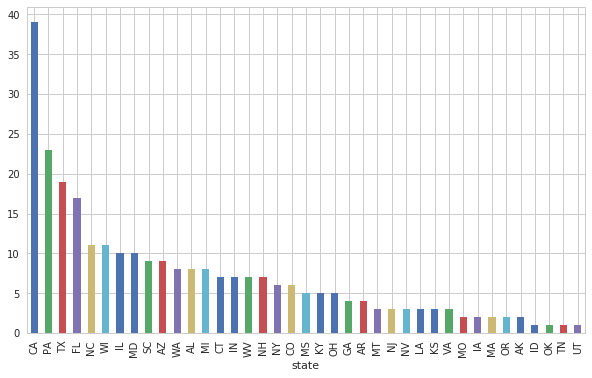

In [61]:
# Statewise counts plotting for both user types
df_state_pd.groupby('state')['count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(10,6));

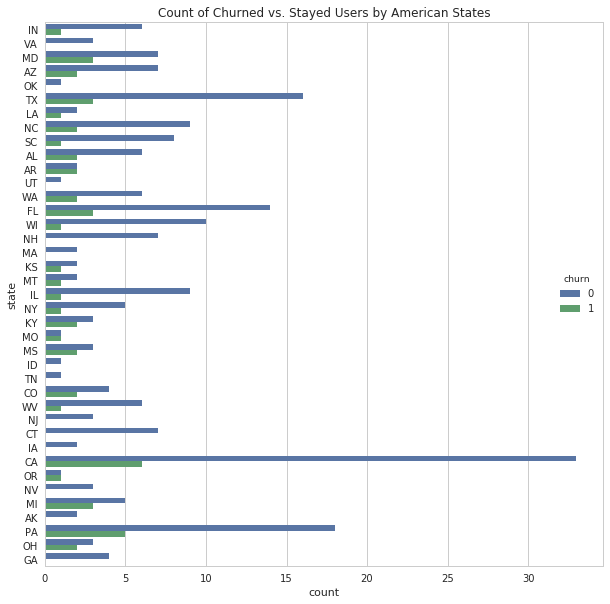

In [62]:
# plot statewise churn vs stay users
plt.figure(figsize=[10,10])
sbrn.barplot(data = df_state_pd, x = 'count', y = 'state', hue = 'churn')
plt.title('Count of Churned vs. Stayed Users by American States');

#location_count.groupby('location')[-2:]
#.sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

#### Churn vs. Stayed users in terms of Songs played every hour

In [63]:
# create function for getting hour of day from timestamp column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [64]:
# create hour column
df = df.withColumn("hour", get_hour(df.ts))

In [65]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, hour='0')

We analyse the stayed user songs playback trend in during hours of day.

In [66]:
# create a df for stayed users count when user clicks next song page
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [67]:
songs_in_hour_stay.show(5)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
+----+-----+
only showing top 5 rows



In [68]:
# convert to pandas and then to numeric
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)

In [69]:
songs_in_hour_stay_pd.head(5)

,hour,count
0,0,9062
1,1,8388
2,2,8336
3,3,8355
4,4,8147


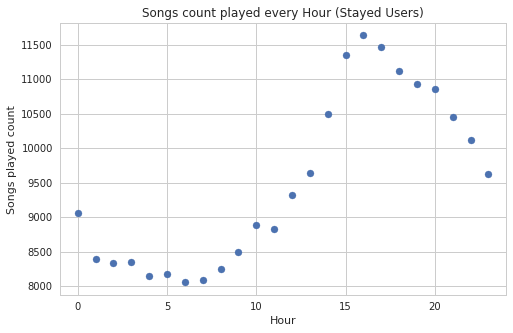

In [70]:
#plot the distribution
plt.figure(figsize = [8,5])
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played count")
plt.title("Songs count played every Hour (Stayed Users)");

From above we infer that Stayed users tend to listening peak of number of songs between late afternoon 3PM and night 8PM.

Similarly we can analyse the pattern of Churn users for their number of songs played hourly everyday.

In [71]:
# dataframe with churned customers and count next song page 
(df.filter((df.page == "Cancellation Confirmation") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))).show()

+----+-----+
|hour|count|
+----+-----+
|   0|    3|
|   1|    1|
|   2|    1|
|   3|    2|
|   4|    2|
|   5|    1|
|   7|    6|
|   8|    1|
|  10|    1|
|  11|    2|
|  12|    2|
|  13|    1|
|  14|    1|
|  15|    4|
|  16|    4|
|  17|    2|
|  18|    3|
|  19|    5|
|  20|    3|
|  21|    3|
+----+-----+
only showing top 20 rows



Above trend shows that the churned user almost never clicked on Next song and simply navigated to cancelled confirmation page.

In [72]:
# Dataframe with churned customers and count "Cancel confirm" song page.
cancellation_churned = df.filter((df.page == "Cancellation Confirmation") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [73]:
cancellation_churned.head()

Row(hour='0', count=3)

In [74]:
# convert to pandas and to numeric
cancellation_churned = cancellation_churned.toPandas()
#cancellation_churned.hour = pd.to_numeric(cancellation_churned.hour)

In [75]:
cancellation_churned.head(5)

,hour,count
0,0,3
1,1,1
2,2,1
3,3,2
4,4,2


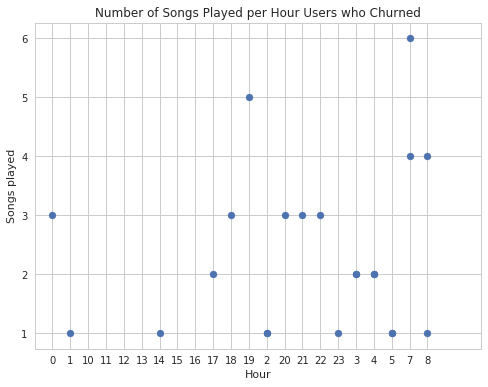

In [76]:
#plot distribution of songs per hour for churned
plt.figure(figsize = [8,6])
plt.scatter(cancellation_churned["hour"], cancellation_churned["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");


We can't infer much from above as its imbalanced and non-conclusive pattern and not much useful for our finding a trend between churned users. Since they simply navigate to cancel without much listening to next songs. Also cancellation is quite random spread during hours.

### UserAgent: For Operating users and Browsers

Hereby we analyse any pattern or effect of OS on users.

In [77]:
# Drop duplicates for user and same browser used multiple times under either level
df_OS = df.drop_duplicates(subset=['userId', 'userAgent', 'churn'])

In [78]:
df_OS = df_OS.select("userAgent", "userId", "churn")
# convert to pandas
df_OS = df_OS.toPandas()

In [79]:
df_OS.head(10)

,userAgent,userId,churn
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",102,0
1,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28,1
2,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",16,0
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3...",128,0
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,1
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,300005,0
6,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32,1
7,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,200010,0
8,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",63,0
9,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,91,0


In [80]:
# get the possible list of operating systems
df_OS.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                29
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       22
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     21
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        15
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     13
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"                        13
"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 

In [81]:
# create list of operating systems
OS_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

In [82]:
# create os column and extract strings that match our os_list and add to column 
df_OS['os'] = df_OS.userAgent.str.extract('(?i)({0})'.format('|'.join(OS_list)))

In [83]:
df_OS.head()

,userAgent,userId,churn,os
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",102,0,Windows
1,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28,1,Windows
2,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",16,0,Windows
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3...",128,0,Mac
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,1,Mac


###### Above shows the user count for their respective OS used. 

In [84]:
# order for the plot
os_order = df_OS.os.value_counts().index

In [85]:
# view os_order
os_order

Index(['Windows', 'Mac', 'iPhone', 'Linux', 'iPad'], dtype='object')

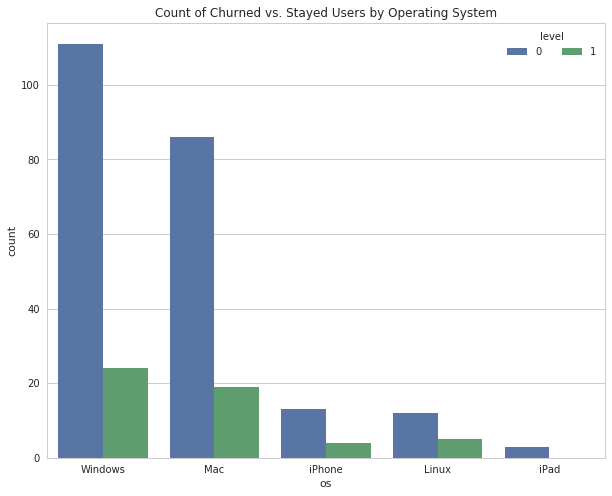

In [86]:
# plot count for churn and non churn users
plt.figure(figsize=[10,8])
sbrn.countplot(data = df_OS, x = 'os', hue ='churn', order = os_order)
plt.title('Count of Churned vs. Stayed Users by Operating System')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Above shows for Churned users for browser Agent used by them. And we can see windows was the most frequent OS used by users.

Similarly we analyse if the browser data is available for churned and non churned users.

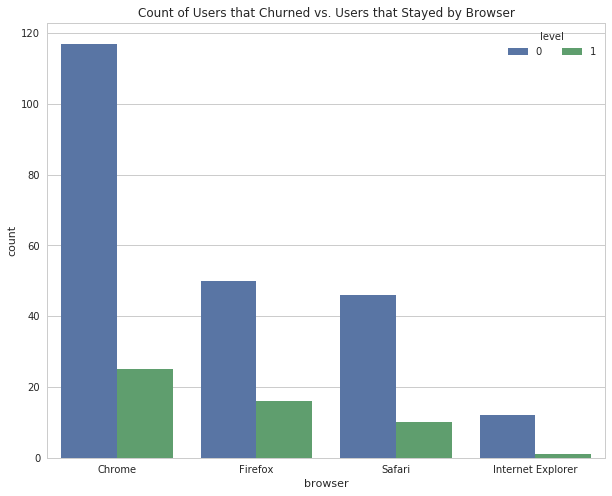

In [87]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]
df_OS['browser'] = df_OS.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))
df_OS.browser.value_counts()
df_OS['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)
# order for the plot
browser_order = df_OS.browser.value_counts().index
plt.figure(figsize=[10,8])
sbrn.countplot(data = df_OS, x = 'browser', hue ='churn', order = browser_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

We can notice most users had chrome so had peaked irrespective of their churn levels.

# Feature Engineering

The features we will try to see here are of 2 types:

Categorical: 
* Gender
* Level

Numerical: 
   Here we can find Total count of:

* Thumbs up actions
* Friends added
* Songs per session
* Rollads actions
* Thumb down actions
* Songs added to playlist
* Different artists listened to on Sparkify
* Days since registering

### Categorical Features

### Gender

Categorical feature for Gender we assume 0 for Male and 1 for Female gender.

In [88]:
cf1_gender = df.select(['userId', 'gender']).dropDuplicates()

In [89]:
# create gender column 
cf1_gender = cf1_gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [90]:
print(cf1_gender.count())
print(cf1_gender.show(20))

225
+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows

None


### Level
Caterory feature for Level for user. The level can change so we need to only take the most recent.

In [91]:
df_cf2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [92]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [93]:
df_cf2 = df_cf2.withColumn("Rank", dense_rank().over(w))

In [94]:
df_cf2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [95]:
cf2_level = df_cf2.filter(df_cf2.Rank == 1).drop(df_cf2.Rank)

In [96]:
cf2_level = cf2_level.drop('ts')

In [97]:
cf2_level = cf2_level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [98]:
print(cf2_level.count())
print(cf2_level.show(20))

225
+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows

None


### Numerical Features

### Thumbs up actions

Numerical feature for total likes/thumbs up actions.

In [99]:
nf1_thumbup = df.select(["userId", "page"])

In [100]:
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [101]:
nf1_thumbup = nf1_thumbup.withColumn("Thumbs Up", thumbup_event("page"))

In [102]:
nf1_thumbup = nf1_thumbup.groupby('userId').sum("Thumbs Up")

In [103]:
nf1_thumbup = nf1_thumbup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [104]:
print(nf1_thumbup.count())
print(nf1_thumbup.show(5))

225
+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
+------+---------+
only showing top 5 rows

None


### Thumbs down actions

Numerical feature counts total likes/thumbs down actions.

In [105]:
nf2_thumbdown = df.select(["userId", "page"])

In [106]:
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [107]:
nf2_thumbdown = nf2_thumbdown.withColumn("Thumbs Down", thumddown_event("page"))

In [108]:
nf2_thumbdown = nf2_thumbdown.groupby('userId').sum("Thumbs Down")

In [109]:
nf2_thumbdown = nf2_thumbdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [110]:
nf2_thumbdown.count()

225

In [111]:
nf2_thumbdown.show(5)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
+------+-----------+
only showing top 5 rows



### Friends Added
Total friends added can indicate if a user is likely to churn or not. In the past, those who added more friends stayed with the app.

In [112]:
nf3_friend = df.select(["userId", "page"])

In [113]:
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [114]:
nf3_friend = nf3_friend.withColumn("add_friend", add_friend("page"))

In [115]:
nf3_friend = nf3_friend.groupby('userId').sum("add_friend")

In [116]:
nf3_friend = nf3_friend.withColumnRenamed("sum(add_friend)", "add_friend")

In [117]:
nf3_friend.count()

225

In [118]:
nf3_friend.show(5)

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|   125|         0|
|    51|        28|
|   124|        74|
+------+----------+
only showing top 5 rows



### Songs per session
This feature will be average number of songs per session for each user.

In [119]:
nf4_song = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

In [120]:
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [121]:
nf4_song = nf4_song.groupby('userId').agg({'count':'avg'})

In [122]:
nf4_song = nf4_song.withColumnRenamed("avg(count)", "avg_song")

In [123]:
nf4_song.count()

225

In [124]:
nf4_song.show(5)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



### Rollads actions
The feature considers number of roll advert actions. This had a higher number of roll ad count for those who churned since those who use the app for free are shown ads whereas paid subscribers aren't shown ads.

In [125]:
nf5_rollad = df.select(["userId", "page"])

In [126]:
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [127]:
#creating rollad column
nf5_rollad = nf5_rollad.withColumn("rollad", rollad_event("page"))

In [128]:
nf5_rollad = nf5_rollad.groupby('userId').sum("rollad")

In [129]:
nf5_rollad = nf5_rollad.withColumnRenamed("sum(rollad)", "roll_ad")

In [130]:
nf5_rollad.count()

225

In [131]:
nf5_rollad.show(5)

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
|   125|      1|
|    51|      0|
|   124|      4|
+------+-------+
only showing top 5 rows



### Songs added to playlist
Those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [132]:
nf6_playlist = df.select(["userId", "page"])

In [133]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [134]:
nf6_playlist = nf6_playlist.withColumn("Playlist", add_playlist("page"))

In [135]:
nf6_playlist = nf6_playlist.groupby('userId').sum("Playlist")

In [136]:
nf6_playlist = nf6_playlist.withColumnRenamed("sum(Playlist)", "playlist")

In [137]:
nf6_playlist.count()

225

In [138]:
nf6_playlist.show(5)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
|   125|       0|
|    51|      52|
|   124|     118|
+------+--------+
only showing top 5 rows



### Different artists listened to on Sparkify
Numerical feature for total number of users that listened to more diverse artists were less likely to churn.

In [139]:
nf7_artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [140]:
nf7_artists = nf7_artists.withColumnRenamed("count", "num_artists")

In [141]:
nf7_artists.count()

225

In [142]:
nf7_artists.show(5)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
|   125|          9|
|    51|       1386|
|   124|       2233|
+------+-----------+
only showing top 5 rows



### Days since registering
Number of days since registering in our above data analysis we observed that users who had a shorter number of days since registering churned more than those who had used the service for a longer time.

In [143]:
# From exploring data analsis as previously done above.
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [144]:
nf8_days = df_days.drop('registration', 'ts', 'churn', 'delta_days')

In [145]:
nf8_days.count()

226

In [146]:
nf8_days.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



### Label
We need to create our label column with user churned denoted by 1 and non churned users represented by 0.

In [147]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [148]:
label = label.drop('count')

In [149]:
label.count()

277

In [150]:
label = label.withColumnRenamed("churn", "label")

In [151]:
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|    73|    0|
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
+------+-----+
only showing top 5 rows



### Features Dataset
We will create the features dataset from above 10 features.

In [152]:
feature_df = cf1_gender \
.join(cf2_level, ["userId"]) \
.join(nf4_song, ["userId"]) \
.join(nf5_rollad, ["userId"]) \
.join(nf1_thumbup, ["userId"]) \
.join(nf2_thumbdown, ["userId"]) \
.join(nf3_friend, ["userId"]) \
.join(nf6_playlist, ["userId"]) \
.join(nf7_artists, ["userId"]) \
.join(nf8_days, ["userId"]) \
.join(label, ["userId"])


In [153]:
feature_df.show(5)

+------+------+-----+------------------+-------+---------+-----------+----------+--------+-----------+-----------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_up|thumbs_down|add_friend|playlist|num_artists|             days|label|
+------+------+-----+------------------+-------+---------+-----------+----------+--------+-----------+-----------------+-----+
|100010|     1|    0|39.285714285714285|     52|       17|          5|         4|       7|        253| 55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|       21|          6|         4|       8|        340|70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|        0|          0|         0|       0|          9|71.31688657407408|    1|
|   125|     0|    0|               8.0|      1|        0|          0|         0|       0|          9|71.31688657407408|    0|
|   125|     0|    0|               8.0|      1|        0|          0|         0|       0|          9|71.316886

In [154]:
# We can drop the userId column
feature_df = feature_df.drop('userId')

In [155]:
feature_df.show(5)

+------+-----+------------------+-------+---------+-----------+----------+--------+-----------+-----------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_up|thumbs_down|add_friend|playlist|num_artists|             days|label|
+------+-----+------------------+-------+---------+-----------+----------+--------+-----------+-----------------+-----+
|     1|    0|39.285714285714285|     52|       17|          5|         4|       7|        253| 55.6436574074074|    0|
|     0|    1|              64.5|      7|       21|          6|         4|       8|        340|70.07462962962963|    0|
|     0|    0|               8.0|      1|        0|          0|         0|       0|          9|71.31688657407408|    1|
|     0|    0|               8.0|      1|        0|          0|         0|       0|          9|71.31688657407408|    0|
|     0|    0|               8.0|      1|        0|          0|         0|       0|          9|71.31688657407408|    1|
+------+-----+------------------+-------

After creating this dataframe with all the features we can into our model where each row represents a user, we need to preprocess the data.

## Preprocessing

In [156]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: integer (nullable = true)



We take these columns and convert into the numerical datatypes that will be used in our model: integers and floats. We try to achieve this using a function complying to DRY principles learnt in the course lesson.

In [157]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [158]:
# verfiy the columns
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



After preprocessing is we will vectorise theses features.

### Vector Assembler
The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [159]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")

In [160]:
feature_df = assembler.transform(feature_df)

In [161]:
feature_df.show()

+------+-----+---------+-------+---------+-----------+----------+--------+-----------+----------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_up|thumbs_down|add_friend|playlist|num_artists|      days|label|        vec_features|
+------+-----+---------+-------+---------+-----------+----------+--------+-----------+----------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|     17.0|        5.0|       4.0|     7.0|      253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|     21.0|        6.0|       4.0|     8.0|      340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|      0.0|        0.0|       0.0|     0.0|        9.0|  71.31689|  1.0|(10,[2,3,8,9],[8....|
|   0.0|  0.0|      8.0|    1.0|      0.0|        0.0|       0.0|     0.0|        9.0|  71.31689|  0.0|(10,[2,3,8,9],[8....|
|   0.0|  0.0|      8.0|    1.0|      0.0|        0.0|       0.0|     0.0|        9.0|  71.31689|  1.0|(10,[2,3,8,9],[8....|


### Standardization
These above found vectors values should be standardise. This is important for our machine learning model so that those features with the highest values don't dominate the results and so that we can make the individual features look like standard normally distributed data.

In [162]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [163]:
scaler_model = scaler.fit(feature_df)

In [164]:
feature_df = scaler_model.transform(feature_df)

In [165]:
feature_df.head(2)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_up=17.0, thumbs_down=5.0, add_friend=4.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0089, 0.0, 0.9179, 2.4152, 0.4025, 0.2749, 0.207, 0.2256, 0.434, 1.4531])),
 Row(gender=0.0, level=1.0, avg_song=64.5, roll_ad=7.0, thumbs_up=21.0, thumbs_down=6.0, add_friend=4.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0685, 1.507, 0.3251, 0.483, 0.3396, 0.207, 0.2579, 0.5832, 1.8299]))]

We can see from above that standardisation has worked by comparing vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), to features=DenseVector([0.0, 2.0685, 1.507, 0.3251, 0.483, 0.3396, 0.207, 0.2579, 0.5832, 1.8299].

## Train / Test / Validation Split
We can see the total number of records.

In [166]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   53|
|  0.0|  226|
+-----+-----+



Now we can split our data into train, test and validation sets. Here we will do a 60:20:20 split and include a seed so we can reproduce the result. Further am  including the same seed for the different machine learning models so that my results can be reproduced.


In [167]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 2001)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:179
Test Dataset:50
Validation Dataset:50


# Modeling
Now we have created our features dataFrame with only numeric variables, we can split the full dataset into train, test, and validation sets. We will test out different machine learning classification algorithms including:

- Logistic Regression
- Random Forest Classifier
- Gradient-Boosted Tree Classifier
- Linear Support Vector Machine
- Naive Bayes
We will use these classification algorithms since churn prediction is a binary classification problem, meaning that customers will either churn (1) or they will stay (0) in a certain period of time.

### Metrics
We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, F1 score is best metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with such imbalanced classes.

Once we start modelling and identify the model with the best F1 score, accuracy and time we will then further tune it.

The models I have selected are below with the reasons why these have been chosen. Each model that has been chosen is suitable for our binary classification problem of predicting churn.

* <b>Logistic Regression:</b> Logistic regression is a reliable machine learning algorithm to try since this is a binary classification problem and logistic regression provides a model with good explainability. Logistic regression is also easy to implement, interpret and is efficient to train. It is also less inclined to overfitting.
* <b>Random Forest:</b> Random Forest is a powerful supervised learning algorithm that can be used for classification. RF is an ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached. This can help avoid overfitting. RF is also robust and has good performance on imbalanced datasets like we have here.
* <b>Gradient Boosted Tree Classifier:</b> GBT provides good predictive accuracy. This works by building one tree at a time where each new tree helps correct errors made by the previous tree compared to RF which builds trees independently. There is a risk of overfitting with GBT so this needs to be considered. However GBT performs well with unbalanced data which we have here.
* <b>Linear SVC:</b> SVC is another supervised learning binary classification algorithm. It works well with clear margins of separations between classes and is memory efficient.
* <b>Naive Bayes:</b> Finally, we will try Naive Bayes. This is another classifier algorithm that is easy to implement and is fast.

### Training the Models & Evaluating the Model Performance

Steps:

* Instantiate
* Fit Models on Train
* Predicting
* Evaluating

In [168]:
# instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=2001)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=2001)
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [169]:
#list of models
model_list = [lr,rf,gbt,lsvc,nb]

In [170]:
# evaluator we are using is multiclassclassificationevaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [171]:
# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 110.78176975250244 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6900392156862745
The accuracy of the LogisticRegression model is: 0.74
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 186.87870502471924 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.6736363636363636
The accuracy of the RandomForestClassifier model is: 0.76
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 224.36991572380066 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassifier is: 0.6775
The accuracy of the GBTClassifier model is: 0.72
LinearSVC training started
LinearSVC training ended
Time taken for LinearSVC is: 19

Now that we have our results we can choose our best model. Accuracy for Linear SVC is the best but comparatively Random Forest and Naive Baies performed well. Also to  notice is that Random Forest and Naive Bayes have same values for F1 score and accuracy. I would select the random forest classifier to tune further.

### Model Tuning for Best Models:
Now we can tune our model using paramGridbuilder and CrossValidator. I am going to select Random Forest since this is the best compromise for F1 score, accuracy. Random Forest had a F1 score of 0.67 and accuracy of 0.76 and took 3 min 16s. Although Naive Bayes has same F1 score and accuracy while being faster in around 2 min 8s, I rather prefer to tune Random Forest algorithm most suited for majority of imbalanced dataset use cases.

### Random Forest

In [172]:
#Examining the parameters to tune.
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

### Parameters
We select numTrees and maxDepth for our RF model tuning.

* NumTrees: Tuning with around 75 trees in all.
* Maxdepth: And limiting to 15 as max depth considering overfitting risk.
* Numfolds: Normally 3 folds will maintain faster processing.

In [173]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10, 30, 75]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [174]:
%%time
cvModel = crossval.fit(train)

CPU times: user 10.2 s, sys: 4.3 s, total: 14.5 s
Wall time: 41min 58s


In [175]:
cvModel.avgMetrics

[0.7002011698185849,
 0.6865169688284578,
 0.6865169688284578,
 0.7008299308423934,
 0.6875576273959989,
 0.6875576273959989,
 0.6996104403920801,
 0.6820345985123142,
 0.6820345985123142]

### Best Model Performance
Here we can infer the final results of Random Forest classifier.

In [177]:
results = cvModel.transform(valid)

In [178]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [179]:
best_model = cvModel.bestModel

In [180]:
# Checking Random Forest was best tuned parameter-value in respect to number of Trees and Depth.
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  30
Best Param (MaxDepth):  5


In [181]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.6736363636363636


In [182]:
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.76


Here our RF model achieved a F1 of 0.67 and accuracy of 0.76. Accuracy are correctly predicted items that being 0.76 or 76%. 
Further we can use this for confusion matrix:

<b>Accuracy = (TP + TN) / (TP + TN + FP + FN)</b>

Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

F1 here is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes.


<b>F1-score = 2 X ((Precision X Recall) / (Precision + Recall))
            
= 2TP / (2TP + FP + FN) </b>


<b>Feature Importance:</b>

Summarizing, we can check the feature importance for our best model and plot this in a chart.

In [183]:
importances = best_model.featureImportances

In [187]:
print(importances)

(10,[0,1,2,3,4,5,6,7,8,9],[0.0227575160173,0.0118088229385,0.0800883934276,0.0828595889342,0.141925934262,0.0943282968082,0.112583634087,0.0708659221526,0.0898116587228,0.29297023265])


In [184]:
x_values = list(range(len(importances)))

In [188]:
print(x_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [185]:
feature_list = list(["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"])

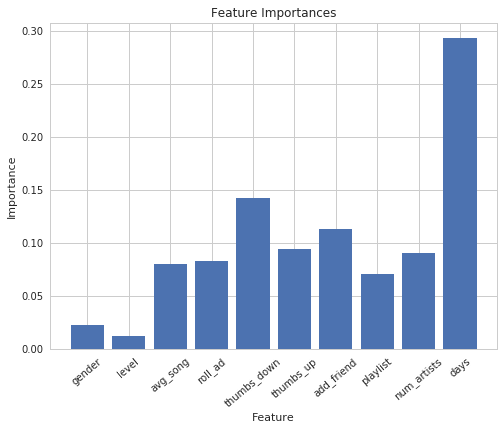

In [189]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

Above graph shows that the feature with the highest importance was days since registered. Gender and level were the least important features.

## Conclusions

To conclude we processed dataset of just 128MB and 277 unique customers records to find prominent features and predict churn rate attaining project's goal. While applying different machine learning algorithms over the newly found features, we derived the optimal one being Random Forest and tuned it further to achieve F1 score: 0.67 with 76% accurate results.

### Business Impact:

Such data proves to be vital for Sparfify and similar businesses entites to foresee users who are prone to churn. 
Such reports are useful for business's marketing teams to target this churn user pool. Perhaps they can incentivize them with discount offers or extended freemium trials.

### Future Work
This project can be improvised by:

* Increasing the collected raw data for precessing to have wider outlook more features/data points on user behaviour. 
* Adding more feature engineering to select the best features to get a better score.
* Trying more algorithms for accuracy and comparions like DecisionTreeClassifier.
